In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append("..")

In [2]:
from typing import Any

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

In [3]:
from data.dataloader import LowLightDataModule
from engine.engine import LightningEngine
from model.blocks.flatten import Flatten, Unflatten
from model.model import LowLightEnhancerLightning

/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_hparams() -> dict[str, Any]:
    hparams: dict[str, Any] = {
        "seed": 42,
        "max_epochs": 100,
        "accelerator": "gpu",
        "devices": 1,
        "precision": "16-mixed",
        "log_every_n_steps": 5,
        "log_dir": "runs/",
        "experiment_name": "train/",
        "inference": "inference/",
        "patience": 20,
        "train_data_path": "data/1_train",
        "valid_data_path": "data/2_valid",
        "bench_data_path": "data/3_bench",
        "infer_data_path": "data/4_infer",
        "image_size": 256,
        "batch_size": 8,
        "num_workers": 10,
        "channels": 3,
        "kernel_size": 15,
        "sigma": 5,
        "embed_dim": 16,
        "num_heads": 1,
        "mlp_ratio": 1,
        "num_resolution": 1,
        "dropout_ratio": 0.2,
    }
    return hparams

In [5]:
hparams: dict[str, Any] = get_hparams()

engine = LightningEngine(
    model_class=LowLightEnhancerLightning,
    hparams=hparams,
    checkpoint_path="../runs/train/version_2/checkpoints/best.ckpt",
)

Seed set to 42


Loading pretrained model LPIPS from /home/user/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=256,
    batch_size=1,
    num_workers=4,
)

data_module.setup()

In [7]:
predict_loaders = data_module.predict_dataloader()


if isinstance(predict_loaders, (list, tuple)):
    loader = predict_loaders[0]
else:
    loader = predict_loaders
loader_iter = iter(loader)

In [8]:
x, _ = next(loader_iter)

x = x.cuda()
model = engine.model.to("cuda")

b, c, h, w = x.shape

x_r, x_g, x_b = x[:, 0:1, :, :], x[:, 1:2, :, :], x[:, 2:3, :, :]
x_r_il, x_r_re = model.model.encoder.separate(x_r)
x_g_il, x_g_re = model.model.encoder.separate(x_g)
x_b_il, x_b_re = model.model.encoder.separate(x_b)

il_concat = torch.concat(tensors=[x_r_il, x_g_il, x_b_il], dim=1)
re_concat = torch.concat(tensors=[x_r_re, x_g_re, x_b_re], dim=1)

il_conv = model.model.encoder.in_conv(il_concat)
re_conv = model.model.encoder.in_conv(re_concat)

il_flat = Flatten(x=il_conv)
re_flat = Flatten(x=re_conv)

il_attn = model.model.encoder.il_sttn(il_flat)
re_attn = model.model.encoder.re_sttn(re_flat)
con_cttn = model.model.encoder.cttn(il_attn, re_attn)

con_unflat = Unflatten(x=con_cttn, h=h, w=w)

con = model.model.encoder.out_conv(con_unflat)

In [9]:
out = model.model.decoder(x, con)

In [10]:
def topil(x, batch):
    if batch:
        return (
            (x.permute(1, 2, 0).detach().cpu().numpy() * 255)
            .clip(0, 255)
            .astype(np.uint8)
        )
    else:
        return (
            (x.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255)
            .clip(0, 255)
            .astype(np.uint8)
        )

In [11]:
x = topil(x=x, batch=False)

x_r_il = topil(x=x_r_il, batch=False)
x_g_il = topil(x=x_g_il, batch=False)
x_b_il = topil(x=x_b_il, batch=False)

x_r_re = topil(x=x_r_re, batch=False)
x_g_re = topil(x=x_g_re, batch=False)
x_b_re = topil(x=x_b_re, batch=False)

con = topil(x=con, batch=False)
out = topil(x=out, batch=False)

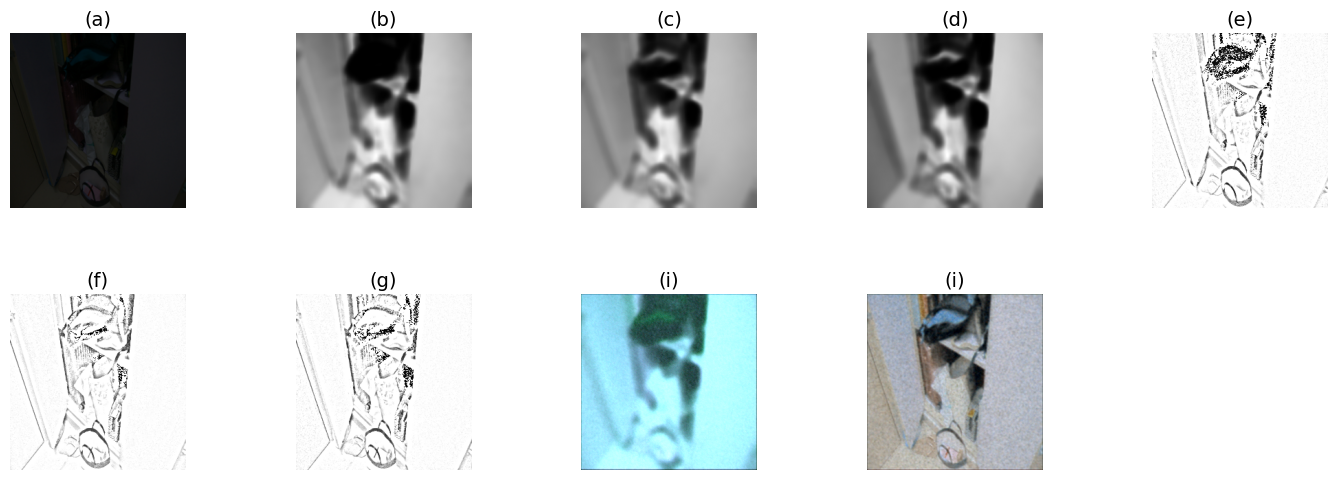

In [12]:
plt.rcParams["font.size"] = 48
plt.figure(figsize=(15, 6))

plt.subplot(2, 5, 1)
plt.imshow(X=x)
plt.title(label="(a)", fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 2)
plt.imshow(X=x_r_il, cmap="gray")
plt.title(label="(b)", fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 3)
plt.imshow(X=x_g_il, cmap="gray")
plt.title(label="(c)", fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 4)
plt.imshow(X=x_b_il, cmap="gray")
plt.title(label="(d)", fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 5)
plt.imshow(X=x_r_re, cmap="gray")
plt.title(label="(e)", fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 6)
plt.imshow(X=x_g_re, cmap="gray")
plt.title(label="(f)", fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 7)
plt.imshow(X=x_b_re, cmap="gray")
plt.title(label="(g)", fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 8)
plt.imshow(X=con, cmap="gray")
plt.title(label="(i)", fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 9)
plt.imshow(X=out, cmap="gray")
plt.title(label="(i)", fontsize=14)
plt.axis(False)


plt.tight_layout()
plt.show()

In [13]:
cv2.imwrite(
    filename="../runs/image/00_x.jpg",
    img=cv2.cvtColor(src=x, code=cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    filename="../runs/image/01_x_r_il.jpg",
    img=x_r_il,
)
cv2.imwrite(
    filename="../runs/image/02_x_g_il.jpg",
    img=x_g_il,
)
cv2.imwrite(
    filename="../runs/image/03_x_b_il.jpg",
    img=x_b_il,
)
cv2.imwrite(
    filename="../runs/image/04_x_r_re.jpg",
    img=x_r_re,
)
cv2.imwrite(
    filename="../runs/image/05_x_g_re.jpg",
    img=x_g_re,
)
cv2.imwrite(
    filename="../runs/image/06_x_b_re.jpg",
    img=x_b_re,
)
cv2.imwrite(
    filename="../runs/image/07_con.jpg",
    img=cv2.cvtColor(src=con, code=cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    filename="../runs/image/08_out.jpg",
    img=cv2.cvtColor(src=out, code=cv2.COLOR_RGB2BGR),
)

True

In [14]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=256,
    batch_size=4,
    num_workers=4,
)

data_module.setup()

In [15]:
predict_loaders = data_module.predict_dataloader()

if isinstance(predict_loaders, (list, tuple)):
    loader = predict_loaders[0]
else:
    loader = predict_loaders
loader_iter = iter(loader)

In [16]:
all_x = []
all_eh = []

for _ in range(3):
    b_x, _ = next(loader_iter)
    b_x = b_x.cuda()

    model = engine.model.to("cuda")

    resutls = model(b_x)

    all_x.append(b_x.cpu())
    all_eh.append(resutls)

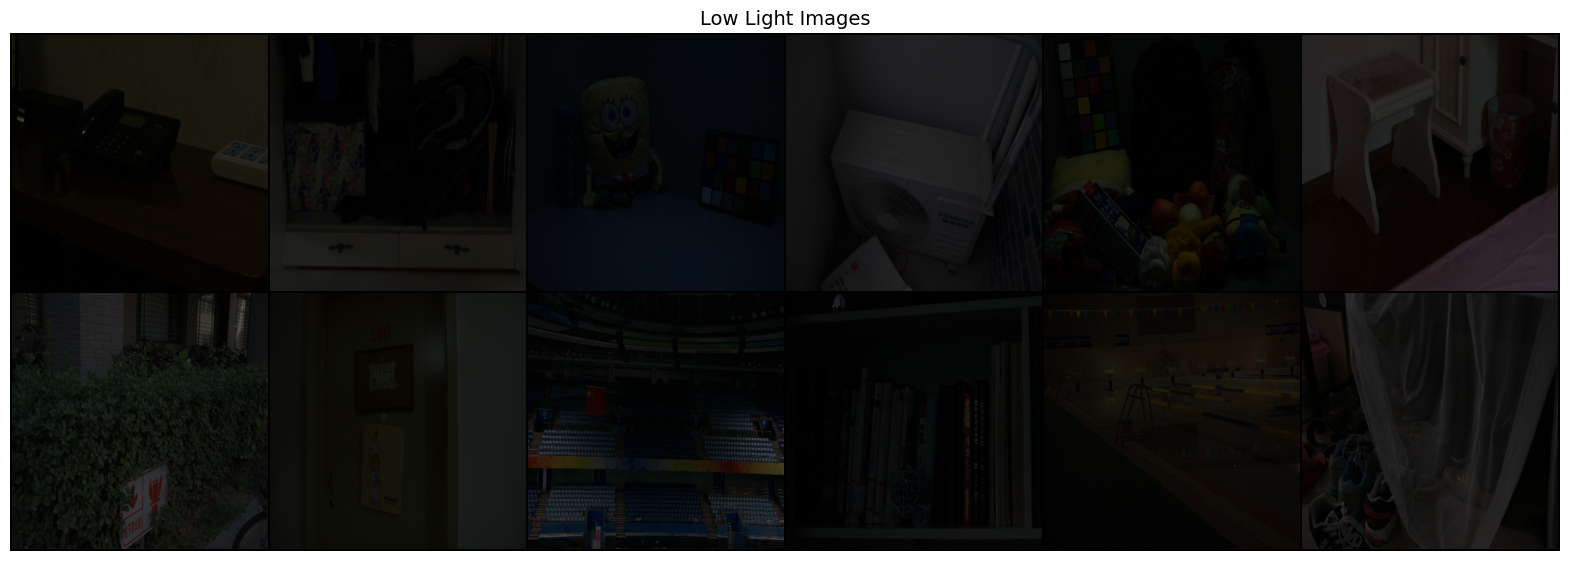

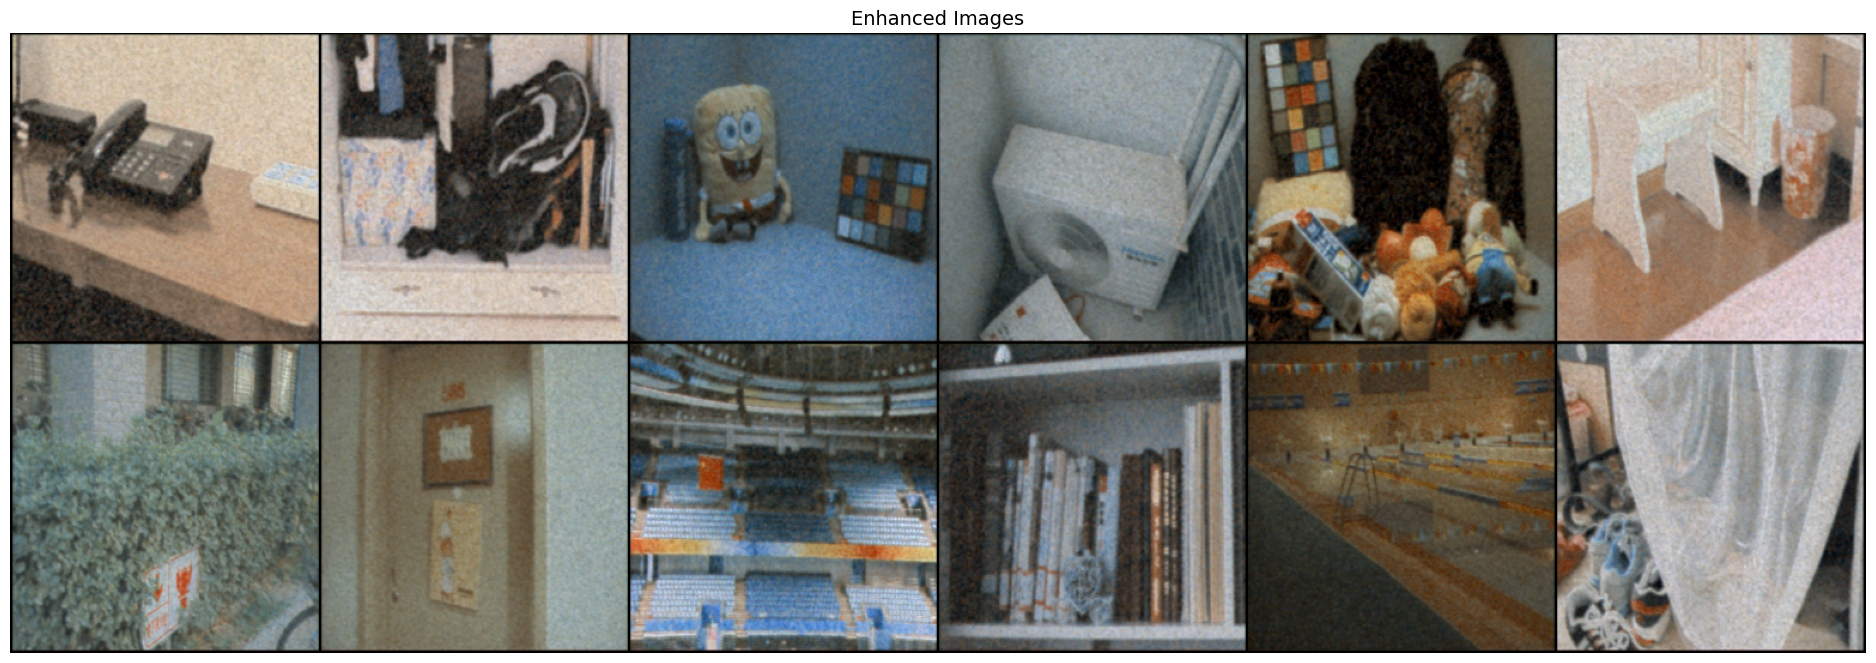

In [17]:
all_x_tensor = torch.cat(tensors=all_x, dim=0)
all_eh_tensor = torch.cat(tensors=all_eh, dim=0)

grid_x = make_grid(tensor=all_x_tensor, nrow=6, padding=2)
grid_eh = make_grid(tensor=all_eh_tensor, nrow=6, padding=2)

np_x = topil(x=grid_x, batch=True)
np_eh = topil(x=grid_eh, batch=True)

plt.figure(figsize=(20, 10))
plt.title(label="Low Light Images", fontsize=14)
plt.imshow(X=np_x)
plt.axis(False)

plt.figure(figsize=(20, 10))
plt.title(label="Enhanced Images", fontsize=14)
plt.imshow(X=np_eh)
plt.axis(False)

plt.tight_layout()
plt.show()

In [18]:
cv2.imwrite(
    filename="../runs/image/09_np_x.jpg",
    img=cv2.cvtColor(src=np_x, code=cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    filename="../runs/image/10_np_eh.jpg",
    img=cv2.cvtColor(src=np_eh, code=cv2.COLOR_RGB2BGR),
)

True